## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Лебедев Аркадий

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 17 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

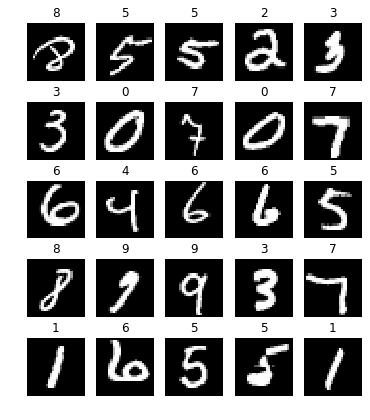

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [8]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

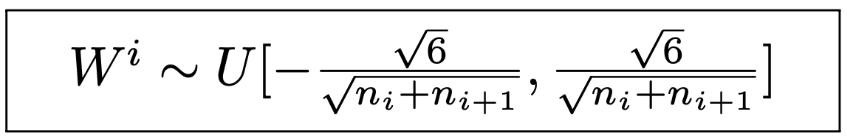

In [9]:
def xavier_init(layer):
    if isinstance(layer, nn.Linear):
        fan_in = layer.weight.size(1)
        fan_out = layer.weight.size(0)
        std = (2.0 / (fan_in + fan_out))**.5
        layer.weight.data.normal_(0, std)
        if layer.bias is not None:
            layer.bias.data.zero_()

In [10]:
xavier_network = nn.Sequential(
    nn.Linear(28*28, 500),
    nn.Tanh(),
    nn.Linear(500, 10)
)

In [11]:
for layer in xavier_network:
    if isinstance(layer, nn.Linear):
        xavier_init(layer)

In [12]:
for layer in xavier_network:
    if isinstance(layer, nn.Linear):
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

In [13]:
he_network = nn.Sequential(
    nn.Linear(28*28, 500),
    nn.ReLU(),
    nn.Linear(500, 10)
)

In [14]:
for layer in he_network:
    if isinstance(layer, nn.Linear):
        init_layer(layer)

In [19]:
for layer in he_network:
    if isinstance(layer, nn.Linear):
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

In [16]:
def check_signal_propagation(net, X):
    X = torch.FloatTensor(X)
    net.zero_grad()
    output = net(X)
    loss = output.sum()
    loss.backward()

In [17]:
print("Xavier initialization:")
check_signal_propagation(xavier_network, X)

Xavier initialization:
forward 1.0064427852630615
forward 0.648313581943512
backward 0.0
backward 14.590577125549316


In [20]:
print("\nHe initialization:")
check_signal_propagation(he_network, X)


He initialization:
forward 1.0064427852630615
forward 16.644371032714844
backward 0.0
backward 226.15850830078125


- Xavier лучше работает с симметричными функциями активации, такими как Tanh, поэтому мы используем nn.Tanh() вместо ReLU
- Xavier инициализация дает более стабильное распространение сигнала 

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

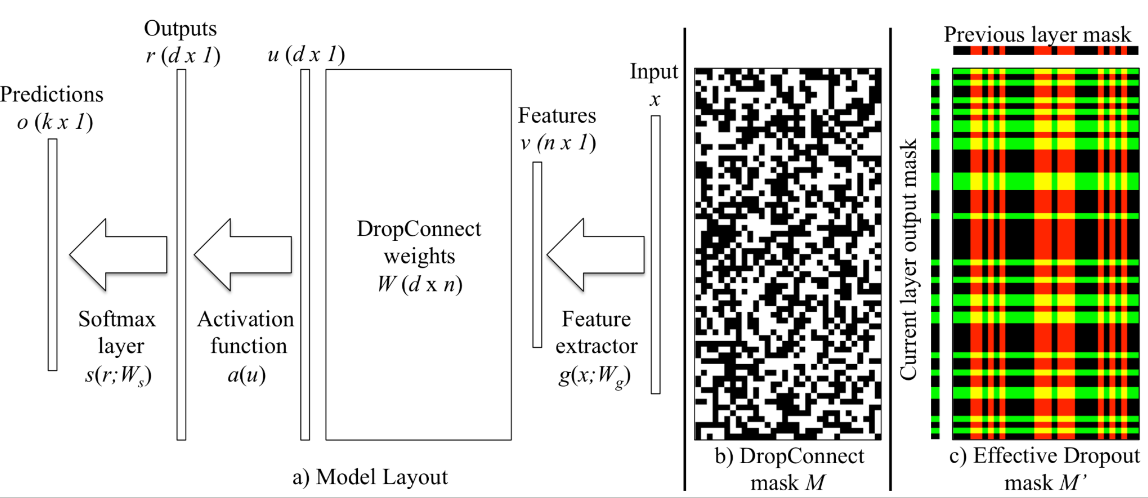

In [21]:
class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.bernoulli(torch.full_like(self.linear.weight, 1 - self.p))
            mask = mask.to(x.device)
            mask = torch.autograd.Variable(mask, requires_grad=False)
        else:
            mask = torch.ones_like(self.linear.weight) * (1 - self.p)
            mask = torch.autograd.Variable(mask, requires_grad=False)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [22]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [34]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10)
]

In [41]:
layers = [
    DropConnect(196, 128, p=0.5),
    nn.ReLU(),
    DropConnect(128, 128, p=0.5),
    nn.ReLU(),
    DropConnect(128, 10, p=0.5)
]

In [48]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [44]:
train_losses = []
test_losses = []

for epoch in range(10):
    network.train()
    epoch_train_losses = []
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    train_losses.append(np.mean(epoch_train_losses))

    network.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)
            epoch_test_losses.append(loss.item())

    test_loss = np.mean(epoch_test_losses)
    test_losses.append(test_loss)
    print('Test Epoch: {}\tLoss: {:.6f}'.format(epoch, test_loss))

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.583866
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.490125
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.460277
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.572652
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.443976
Test Epoch: 0	Loss: 0.265583
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.397970
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.650272
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.302241
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.321830
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.466859
Test Epoch: 1	Loss: 0.194391
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.278910
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.293921
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.233878
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.323854
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.322977
Test Epoch: 2	Loss: 0.168108
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.387268
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.254028
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.189010
Train Epoch: 3 [38400/60000 (64%)

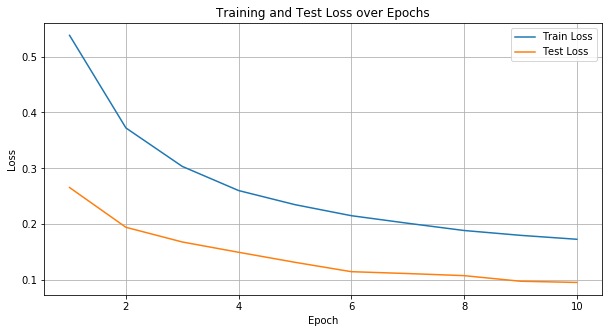

In [45]:
#DropConnect
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

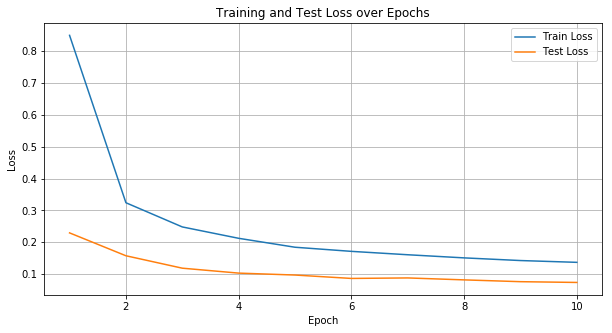

In [37]:
#Dropout
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

- Dropout показывает более быструю начальную сходимость.
- Dropout демонстрирует более стабильное обучение.
- Dropout достигает более высокой точности на обучающем наборе.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

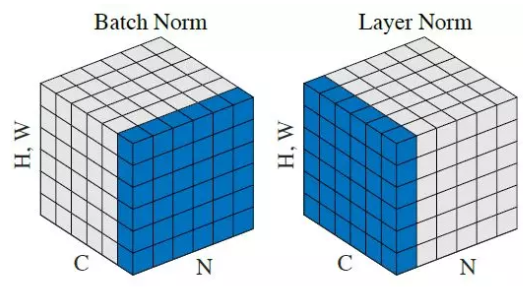

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [46]:
class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        output = (x - mean) / (std + self.eps)
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [47]:
layers = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [52]:
layers = [
    nn.Linear(196, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [53]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [54]:
train_losses = []
test_losses = []

for epoch in range(10):
    network.train()
    epoch_train_losses = []
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    train_losses.append(np.mean(epoch_train_losses))

    network.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)
            epoch_test_losses.append(loss.item())

    test_loss = np.mean(epoch_test_losses)
    test_losses.append(test_loss)
    print('Test Epoch: {}\tLoss: {:.6f}'.format(epoch, test_loss))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307601
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.297072
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.930495
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.657234
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.432735
Test Epoch: 0	Loss: 1.316389
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.334068
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.298587
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.129848
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.925877
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.991374
Test Epoch: 1	Loss: 0.922736
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.954590
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.815582
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.937959
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.670867
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.622105
Test Epoch: 2	Loss: 0.722833
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.712562
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.690258
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.670941
Train Epoch: 3 [38400/60000 (64%)

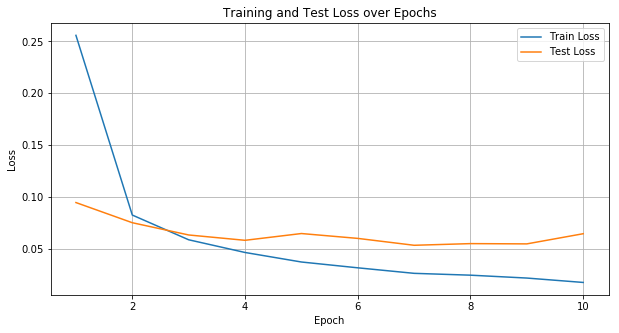

In [51]:
#BatchNorm1d
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

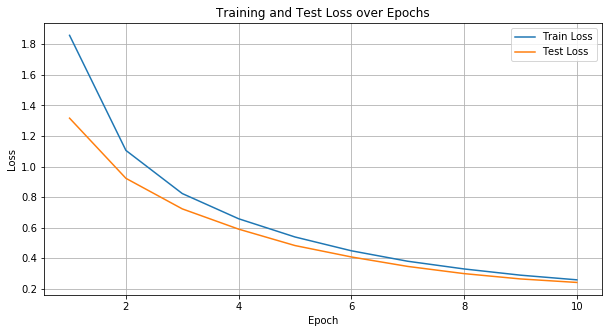

In [55]:
#LayerNormalization
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

- Batch Normalization показал более быструю сходимость на начальных этапах обучения
- Layer Normalization более стабильный
- Обе нормализации помогают в борьбе с проблемой исчезающих/взрывающихся градиентов и ускоряют обучение по сравнению с сетью без нормализации.
